In [16]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, \
                            auc,\
                            f1_score, \
                            recall_score, \
                            precision_score, \
                            classification_report

In [53]:
n_samples=1500
n_features=2
data = make_classification(n_samples=n_samples,
                           n_classes=2,
                           n_features=n_features,
                           n_clusters_per_class=1,
                           n_informative=n_features, 
                           n_redundant=0, 
                           n_repeated=0,
                           flip_y=0.0,
                           random_state=42
                          )
feature_cols = [f'x{i}' for i in range(1,n_features+1)]
X = pd.DataFrame(data[0], columns = feature_cols)
y = pd.DataFrame(data[1], columns = ['y'])
df = pd.concat([X, y], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
print(df_train.shape)
df.head(3)

(1050, 3)


,x1,x2,y
0,-2.799877,-0.136802,0
1,-1.367893,1.101364,0
2,-1.372660,0.543190,0


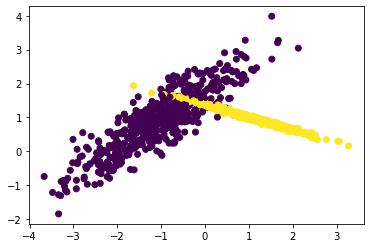

In [54]:
pl.scatter(df_train['x1'], df_train['x2'], c=df_train['y'])

In [19]:
def prepare_U_L_data(df, in_label_col, out_label_col, u_frac):
    """ Hide fraction of labels to make unlabeled dataset 
        input:
        df: dataframe 
        l_frac: fraction of labeled dataset
        u_frac: fraction of unlabeled dataset
    """
    if (u_frac < 0.) | (u_frac > 1.0) :
        print("Error: u_frac must be between 0 and 1")
    df_u = df.sample(frac=u_frac).copy()
    df_l = df[~df.index.isin(df_u.index)].copy()
    print(df_u.shape)
    print(df_l.shape)
    df_u.loc[:, out_label_col] = -1
    df_l.loc[:, out_label_col] = df_l.loc[:, in_label_col]
    return pd.concat([df_u, df_l])

In [20]:
def data_sampler(df: pd.DataFrame,
                 label_column='label',
                 l_frac=1.,
                 u_frac=0.1):
    """ Return fraction of data for label and unlabel dataset
        
        input:
        df: dataframe with collection of both labeled and unlabeled data. The unlabeled
        data are specified with label -1
        l_frac: desired fraction of labeled dataset
        u_frac: desired fraction of unlabeled dataset
    """
    df_u = df[df[label_column] == -1 ]
    df_l = df[df[label_column] != -1]
    
    df_u_sample = df_u.sample(frac=u_frac)
    df_l_sample = df_l.sample(frac=l_frac)
    
    return pd.concat([df_u_sample, df_l_sample])
    

In [44]:
def self_trainer(ml_trainer, 
                 feature_cols, 
                 target_col, 
                 df_train,
                 df_test,
                 l_frac, 
                 u_frac, 
                 n_realization):
#     fs = []
#     pc = []
#     rc = []
    roc = []
    for i in range(n_realization): # loop on realizations
        df_aux = data_sampler(df_train, target_col, l_frac=l_frac, u_frac=u_frac)
        ml_trainer.fit(df_aux[feature_cols], df_aux[target_col])
        test_prediction = ml_trainer.predict(df_test[feature_cols])

#         fs.append(f1_score(df_test_sample[target_col], 
#                           test_prediction))
#         pc.append(precision_score(df_test_sample['label'], 
#                           test_prediction, zero_division=0))
#         rc.append(recall_score(df_test_sample['label'], 
#                           test_prediction))
        roc.append(roc_auc_score(df_test[target_col], 
                          test_prediction))
    return np.mean(roc), roc

In [45]:
df_out = prepare_U_L_data(df_train, 'y', 'y', 0.5)

(525, 6)
(525, 6)


In [46]:
df_out['y'].value_counts()

-1    525
 1    265
 0    260
Name: y, dtype: int64

In [47]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
cl_self = Pipeline([('self-clf', SelfTrainingClassifier(sgd, threshold=0.95))])

In [48]:
roc_scores = {}
roc_std = {}
for l_frac in np.linspace(0.05, 1, 10):
    roc_scores[l_frac] = []
    roc_std[l_frac] = []
    for u_frac in np.linspace(0.001, 1, 10):
        roc, _ = self_trainer(ml_trainer=cl_self, 
                           feature_cols=feature_cols,
                           target_col='y',
                           df_train=df_out,
                           df_test=df_test,
                           l_frac=l_frac, 
                           u_frac=u_frac, 
                           n_realization=10)
        roc_scores[l_frac].append(roc)

Text(0, 0.5, 'ROC Score')

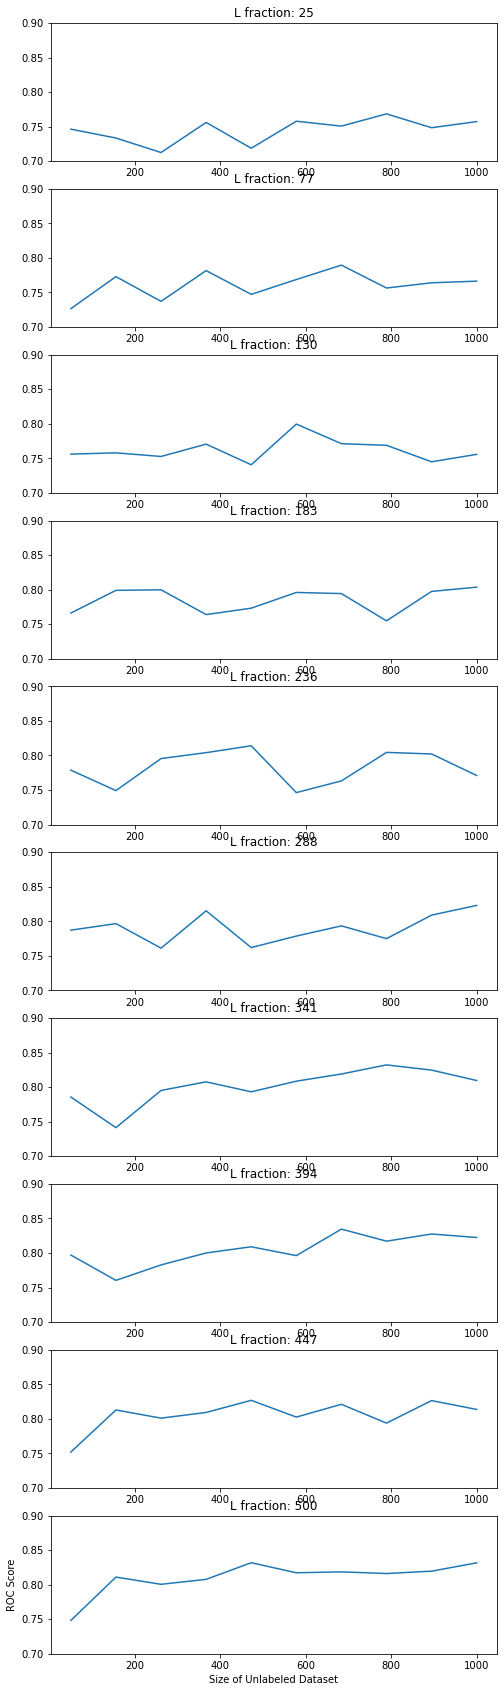

In [50]:
fig, ax = pl.subplots(10, 1, figsize=(8,30))
for i, k in enumerate(roc_scores.keys()):
    ax[i].plot(1000*np.linspace(0.05, 1, 10), roc_scores[k])
    ax[i].set_title('L fraction: {:}'.format(int(k*500)))
    ax[i].set_ylim(0.7, 0.9)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')
#pl.savefig('f1_usize_multi.pdf')